## Forecasting Energy

The aim of this notebook is to build a model for forecasting electricity prices in Spain. It's based on the datasets provided by: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather which contains two datasets:

1. **Hourly** data from  2015 to 2018 of **electricity generation** (by different types e.g. solar, wind, fossil gas etc.), **generation forecasts** (exclusively for wind and solar energy), actual and forecasted **demand** (in total load), & **prices** (day-ahead and actual)


2. **Hourly** data from  2015 to 2018 of Technical & Descriptive **Weather info** from the **5 largest Spanish Cities** ('Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville')

Given the data listed above, we aim to find what variables are most relevant and are most useful at predicting electricity prices & feed them into a model that ideally should reflect reality as best as possible.



## Notebook Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


## Importing Data

In [2]:
#1st dataset
df_energy = pd.read_csv(r'C:\Users\t_bor\Anaconda\Projetos\EE Forecast\Data\energy_dataset.csv')
#2nd dataset
df_weather = pd.read_csv(r'C:\Users\t_bor\Anaconda\Projetos\EE Forecast\Data\weather_features.csv')

## Data Preprocessing & Cleaning

#### 1st Dataset (Energy)

In [3]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
df_energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [6]:
df_energy.duplicated().sum()

0

In [7]:
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


Some of the energy dataset columns are either completely empty (having NaN or 0): these columns don't seem to be valuable for our analysis, hence we drop them. 

Regarding the columns with a few NaNs we need to find the best possible alternative to deal with them without distorting our analysis. Most of these columns have either 18 or 19 NaNs total, which might indicate a pattern.

In [8]:
df_energy = df_energy.loc[:, ~df_energy.columns.isin(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation marine','generation wind offshore'])]

In [9]:
missing_rows = df_energy.loc[df_energy.isnull().any(axis=1)]
missing_rows

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
99,2015-01-05 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,546.0,8233.0,21912.0,21182.0,35.20,59.68
108,2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3932.0,9258.0,23209.0,NaN,35.50,79.14
109,2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4236.0,9156.0,23725.0,NaN,36.80,73.95
110,2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4215.0,9072.0,23614.0,NaN,32.50,71.93
111,2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4050.0,8779.0,22381.0,NaN,30.00,71.50
112,2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3728.0,8426.0,21371.0,NaN,30.00,71.85
113,2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3175.0,7946.0,20760.0,NaN,30.60,80.53
451,2015-01-19 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,91.0,6434.0,38642.0,39304.0,70.01,88.95
452,2015-01-19 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,28.0,6907.0,38758.0,39262.0,69.00,87.94
643,2015-01-27 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,182.0,9807.0,38968.0,38335.0,66.00,83.97


Generally, for a given row, when a type of generation is 'NaN' all the others Generation & 'total load actual' columns tend to be 'NaN' too. Regarding 'total load actual', it appears to have some isolated cases with NaNs where all other columns have values.

For Generation, missing values tend to be spread across time with the exception of the date '2015-01-05', the same applies to 'total load actual'. Given electricity production & demand tends to follow repetitive daily patterns that makes interpolation easy

<AxesSubplot:>

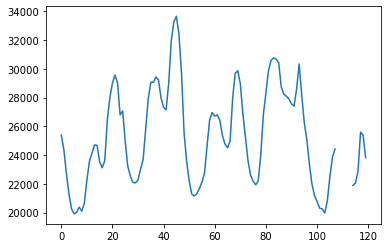

In [10]:
#e.g. plotting the first 5 days of the dataset for 'total load actual' we observe repetitive patterns everyday
#hence we opt for interpolation to treat nans
df_energy['total load actual'].head(120).plot()

In [11]:
df_energy=df_energy.interpolate()

<AxesSubplot:>

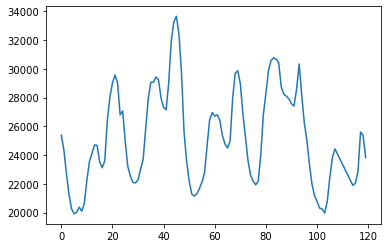

In [12]:
#First 5 days after interpolation
df_energy['total load actual'].head(120).plot()

The Energy Dataset seems to be ready, we cleared missing values and made sure there were no duplicates. Regarding Outliers, the description table of each column did not seem to raise any alarm.

#### 2nd Dataset (Weather)

In [13]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [15]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [16]:
df_weather.isnull().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [17]:
df_weather.duplicated(subset=['dt_iso','city_name']).sum()

3076

In [18]:
df_weather.duplicated().sum()

21

In [19]:
df_weather[df_weather.duplicated(subset=['dt_iso','city_name'])]

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
125,2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3982,2015-06-15 21:00:00+02:00,Valencia,289.610,288.650,290.930,1018,100,3,330,0.9,0.0,0.0,75,200,thunderstorm,thunderstorm with light rain,11d
3984,2015-06-15 22:00:00+02:00,Valencia,289.240,288.150,290.370,1018,100,2,300,0.9,0.0,0.0,75,201,thunderstorm,thunderstorm with rain,11n
4774,2015-07-18 19:00:00+02:00,Valencia,299.770,298.750,300.930,1013,83,4,120,0.9,0.0,0.0,20,201,thunderstorm,thunderstorm with rain,11d
5091,2015-07-31 23:00:00+02:00,Valencia,295.890,293.710,297.590,1009,88,3,70,3.0,0.0,0.0,90,211,thunderstorm,thunderstorm,11n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178040,2018-12-17 08:00:00+01:00,Seville,282.830,282.150,283.150,1029,93,3,60,0.0,0.0,0.0,90,741,fog,fog,50n
178089,2018-12-19 08:00:00+01:00,Seville,286.800,286.150,287.150,1024,93,2,350,0.3,0.0,0.0,40,500,rain,light rain,10n
178091,2018-12-19 09:00:00+01:00,Seville,284.930,283.150,286.150,1024,100,1,320,0.0,0.0,0.0,20,741,fog,fog,50d
178262,2018-12-26 11:00:00+01:00,Seville,280.740,279.150,283.150,1030,87,3,50,0.0,0.0,0.0,0,741,fog,fog,50d


Overall, this dataset seems to be mostly clean and unlike df_energy it has no NaNs. Nevertheless, we found 3076 duplicated rows when sorting by datetime & city (21 duplicates when considering all columns) and found a couple of outliers which are not "physically" possible: 
- wind_speed Maximum value of 133 m/s (The worst hurricane in the past century "Cuba Hurricane" is expected to have reached 75 m/s at its peak) 
- pressure Maximum value 1008371 mb (the standard pressure at sea-level is roughly 1013 mb)

##### Outliers

In [20]:
df_weather.sort_values(by='wind_speed', ascending = False).head(50)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
20725,2017-05-11 12:00:00+02:00,Valencia,293.150000,293.150000,293.150000,1002,52,133,20,0.0,0.0,0.0,20,801,clouds,few clouds,02d
708,2015-01-30 11:00:00+01:00,Valencia,289.750000,289.750000,289.750000,997,62,64,314,0.0,0.0,0.0,0,800,clear,sky is clear,01d
712,2015-01-30 15:00:00+01:00,Valencia,290.950000,290.950000,290.950000,993,58,54,262,0.0,0.0,0.0,0,800,clear,sky is clear,01d
1295,2015-02-23 22:00:00+01:00,Valencia,286.950000,286.950000,286.950000,1010,64,43,304,0.0,0.0,0.0,0,800,clear,sky is clear,01n
713,2015-01-30 16:00:00+01:00,Valencia,290.716687,290.716687,290.716687,993,59,40,244,0.0,0.0,0.0,0,800,clear,sky is clear,01
716,2015-01-30 19:00:00+01:00,Valencia,288.750000,288.750000,288.750000,993,74,38,252,0.0,0.0,0.0,0,800,clear,sky is clear,01n
700,2015-01-30 03:00:00+01:00,Valencia,288.350000,288.350000,288.350000,998,67,35,304,0.0,0.0,0.0,0,800,clear,sky is clear,01n
707,2015-01-30 10:00:00+01:00,Valencia,289.150000,289.150000,289.150000,997,64,33,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d
687,2015-01-29 14:00:00+01:00,Valencia,289.250000,289.250000,289.250000,1008,43,30,262,0.0,0.0,0.0,0,800,clear,sky is clear,01d
374,2015-01-16 13:00:00+01:00,Valencia,284.950000,284.950000,284.950000,1012,49,30,255,0.0,0.0,0.0,20,801,clouds,few clouds,02d


In [21]:
df_weather.sort_values(by='pressure', ascending = False).head(50)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
108589,2015-02-21 02:00:00+01:00,Barcelona,283.250000,283.250000,283.250000,1008371,0,3,337,12.0,0.00,0.0,12,503,rain,very heavy rain,10n
108619,2015-02-22 08:00:00+01:00,Barcelona,281.750000,281.750000,281.750000,1002881,0,1,22,0.0,0.00,0.0,0,800,clear,sky is clear,01d
108618,2015-02-22 07:00:00+01:00,Barcelona,279.870000,279.870000,279.870000,1002241,0,0,0,0.0,0.00,0.0,0,800,clear,sky is clear,01n
108596,2015-02-21 09:00:00+01:00,Barcelona,284.050000,284.050000,284.050000,1001781,0,9,292,0.0,0.00,0.0,92,804,clouds,overcast clouds,04d
108597,2015-02-21 10:00:00+01:00,Barcelona,284.050000,284.050000,284.050000,1001501,0,2,337,0.0,0.00,0.0,92,804,clouds,overcast clouds,04d
108598,2015-02-21 11:00:00+01:00,Barcelona,274.650000,274.650000,274.650000,1000951,0,2,337,0.3,0.00,0.0,92,500,rain,light rain,10d
108572,2015-02-20 09:00:00+01:00,Barcelona,284.360000,284.360000,284.360000,102153,0,1,275,0.0,0.00,0.0,0,800,clear,sky is clear,01d
108573,2015-02-20 10:00:00+01:00,Barcelona,286.360000,286.360000,286.360000,102132,0,1,275,0.0,0.00,0.0,0,800,clear,sky is clear,01d
108574,2015-02-20 11:00:00+01:00,Barcelona,286.050000,286.050000,286.050000,102075,0,2,67,12.0,0.00,0.0,0,503,rain,very heavy rain,10d
108575,2015-02-20 12:00:00+01:00,Barcelona,286.050000,286.050000,286.050000,101983,0,2,219,0.0,0.00,0.0,0,800,clear,sky is clear,01d


In [22]:
#Barcelona clearly has wrong pressure measurements
#We replace these impossible values with NaNs... while 1090mb may be a plausible maximum 10029 is not:
df_weather.loc[df_weather.pressure >= 10029, 'pressure'] = np.nan

In [23]:
#the highest wind speed ever recorded in Spain was 202 kilometers per hour (56.1 meters per second), 
#which occurred during a storm in February 2020 in the province of Tarragona, Catalonia
#Hence, it is only fair we cap our data's maximum windspeed to 56.1 m/s and remove values above this cap
df_weather.loc[df_weather.wind_speed >= 56.1, 'wind_speed'] = np.nan

In [24]:
#Similarly to df_energy we will deal with NaNs by interpolation
#we need to ensure rows are sorted by city (otherwise we might accidentally interpolate a given value for a city with data from another)
df_weather.sort_values(by= ['city_name', 'dt_iso'], inplace = True)
df_weather=df_weather.interpolate()


##### Duplicates

In [25]:
#We now drop duplicates from our dataset, based on the dt_iso & city_name columns
df_weather = df_weather.drop_duplicates(subset = ['dt_iso','city_name'])

#### Merging Datasets

In order to forecast generation, pumping & demand of electricity for a given hour, we merge both datasets as weather is a core determinant. To make the merged dataset easy to feed into a Machine Learning model, we transform df_weather into a pivot table format.

In [26]:
 df_weather_pivot = pd.pivot_table(df_weather, index='dt_iso', columns='city_name').reset_index()

In [27]:
# Flatten the MultiIndex columns into standard columns
df_weather_pivot.columns = [' '.join(col).strip() for col in df_weather_pivot.columns.values]

In [28]:
df_weather_pivot.head(5)

,dt_iso,clouds_all Barcelona,clouds_all Bilbao,clouds_all Madrid,clouds_all Seville,clouds_all Valencia,humidity Barcelona,humidity Bilbao,humidity Madrid,humidity Seville,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
0,2015-01-01 00:00:00+01:00,0,0,0,0,0,100,97,63,75,...,58,226,309,21,62,7.0,0.0,1.0,1.0,1.0
1,2015-01-01 01:00:00+01:00,0,0,0,0,0,100,97,63,75,...,58,229,309,21,62,7.0,0.0,1.0,1.0,1.0
2,2015-01-01 02:00:00+01:00,0,0,0,0,0,100,97,64,71,...,48,224,273,27,23,7.0,1.0,1.0,3.0,0.0
3,2015-01-01 03:00:00+01:00,0,0,0,0,0,100,97,64,71,...,48,225,273,27,23,7.0,1.0,1.0,3.0,0.0
4,2015-01-01 04:00:00+01:00,0,0,0,0,0,100,97,64,71,...,48,221,273,27,23,7.0,1.0,1.0,3.0,0.0


In [29]:
#merging df_energy and df_weather_pivot based on dt_iso

#Renaming 'dt_iso' to 'time' to match the merging key
df_weather_pivot.rename({'dt_iso' : 'time'}, axis = 1, inplace = True)

#merging
df_final = df_energy.merge(df_weather_pivot, how = 'left', on='time')
df_final.sort_values(by='time')

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,58,226,309,21,62,7.0,0.0,1.0,1.0,1.0
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,58,229,309,21,62,7.0,0.0,1.0,1.0,1.0
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,48,224,273,27,23,7.0,1.0,1.0,3.0,0.0
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,48,225,273,27,23,7.0,1.0,1.0,3.0,0.0
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,48,221,273,27,23,7.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,250,57,280,30,140,1.0,0.0,1.0,3.0,2.0
35060,2018-12-31 20:00:00+01:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,270,0,260,30,242,3.0,1.0,1.0,3.0,1.0
35061,2018-12-31 21:00:00+01:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,300,140,340,50,300,4.0,1.0,1.0,4.0,3.0
35062,2018-12-31 22:00:00+01:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,320,120,340,60,310,5.0,1.0,2.0,4.0,2.0


## EDA

Exploratory Data Analysis

In [30]:
#Firstly we prepare our hourly timeseries & create a second dataframe with daily granularity of hourly averages to find long-term trends 

#Using UTC time
df_final['time'] = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True, format = "%Y-%m-%d %H:%M:%S") #important to set utc = True otherwise we get ValueError

#create resample of the data on a daily basis
df_daily = df_final.set_index('time').resample('D').mean()
df_daily_ts = df_daily
df_daily = df_daily.reset_index()

In [31]:
df_final.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,58,226,309,21,62,7.0,0.0,1.0,1.0,1.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,58,229,309,21,62,7.0,0.0,1.0,1.0,1.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,48,224,273,27,23,7.0,1.0,1.0,3.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,48,225,273,27,23,7.0,1.0,1.0,3.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,48,221,273,27,23,7.0,1.0,1.0,3.0,0.0


In [32]:
df_daily.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
0,2014-12-31 00:00:00+00:00,447.000000,329.000000,4844.000000,4821.000000,162.000000,863.000000,1051.000000,1899.000000,7096.000000,...,58.000000,226.000000,309.000000,21.000000,62.000000,7.000000,0.000000,1.000000,1.000000,1.000000
1,2015-01-01 00:00:00+00:00,425.208333,243.708333,4187.791667,4099.458333,161.500000,1088.208333,1056.916667,2249.041667,7097.416667,...,213.166667,208.666667,234.250000,43.375000,224.875000,4.041667,0.875000,0.875000,2.875000,1.000000
2,2015-01-02 00:00:00+00:00,389.875000,0.000000,3566.166667,1258.125000,200.833333,1510.833333,1300.000000,3708.625000,7105.416667,...,295.208333,241.500000,219.208333,50.833333,262.541667,1.750000,0.958333,1.000000,3.041667,1.125000
3,2015-01-03 00:00:00+00:00,436.875000,0.000000,3451.791667,1375.958333,229.791667,1361.083333,1378.041667,3897.416667,7094.958333,...,250.625000,230.708333,144.375000,48.583333,267.541667,2.250000,0.791667,0.958333,1.958333,1.833333
4,2015-01-04 00:00:00+00:00,396.375000,13.583333,3526.125000,2315.291667,356.625000,573.541667,1481.916667,3245.291667,6956.541667,...,165.500000,203.416667,99.541667,102.375000,223.041667,1.208333,0.708333,0.958333,2.041667,1.333333


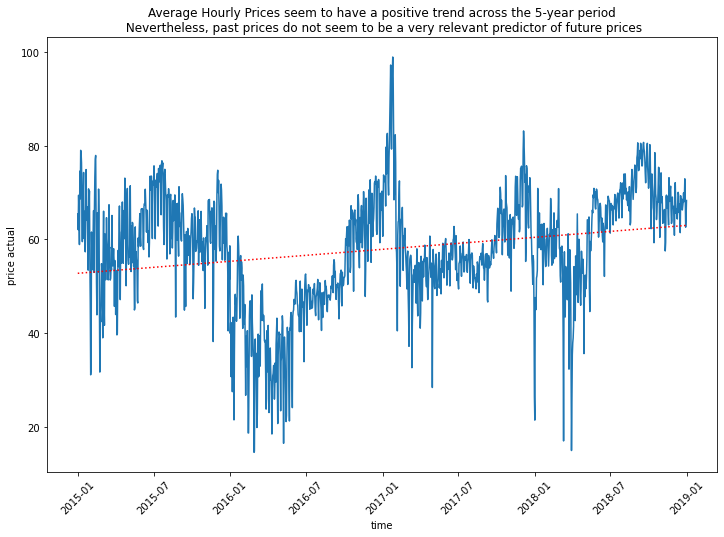

In [33]:
#Plotting Average Hourly Price Evolution
#initializing chart
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
#Adding price data
sns.lineplot(x='time', y='price actual', data=df_daily)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#Adding a Trendline
z = np.polyfit(df_daily.index, df_daily['price actual'], 1)
p = np.poly1d(z)
plt.plot(df_daily.time, p(df_daily.index), color='r', ls =':')

plt.title('Average Hourly Prices seem to have a positive trend across the 5-year period\n Nevertheless, past prices do not seem to be a very relevant predictor of future prices')
plt.show()

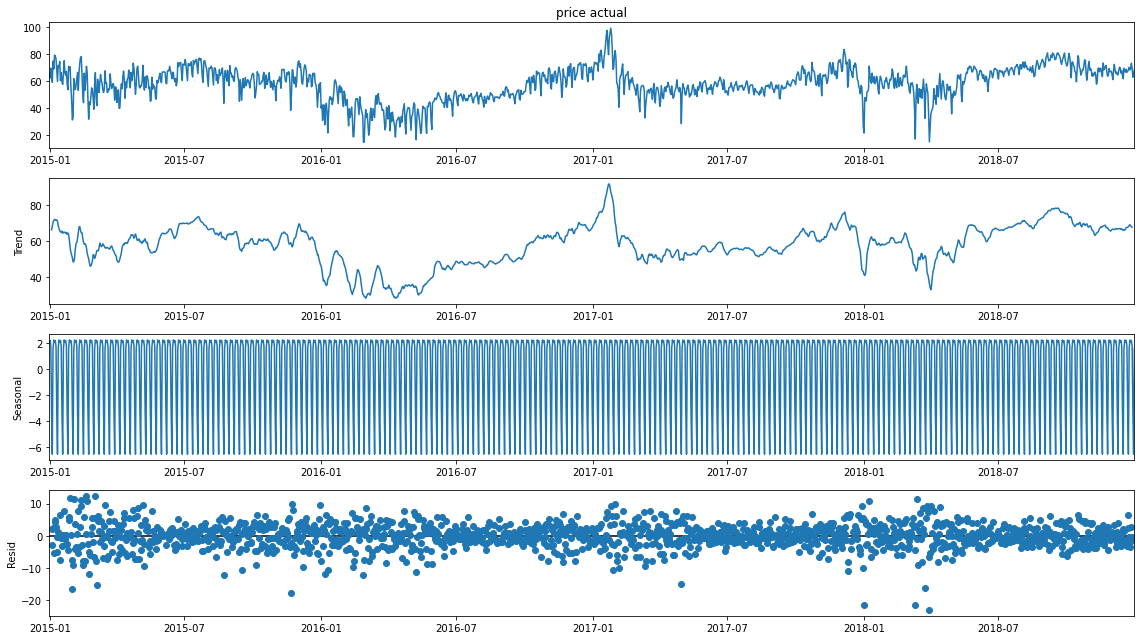

In [34]:
y = df_daily_ts['price actual']

seasonal_decomp = seasonal_decompose(y, model="additive")
fig = seasonal_decomp.plot()

fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

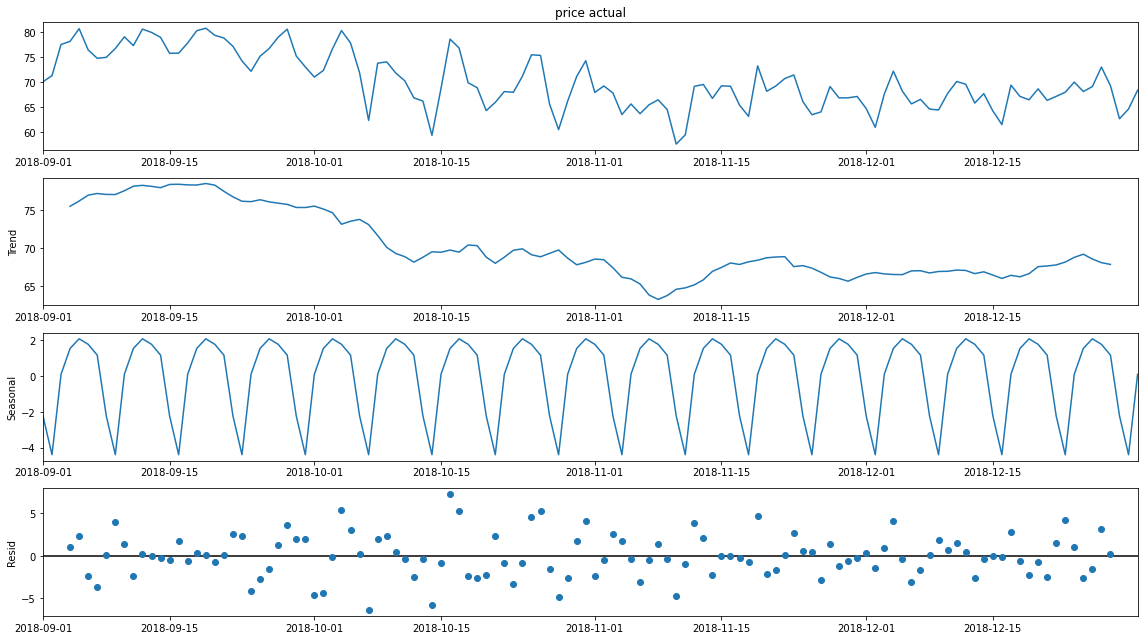

In [35]:
#Plotting last Months
y = df_daily_ts.loc[df_daily_ts.index.tz_convert(None) > dt.datetime(2018, 8, 31),'price actual']

seasonal_decomp = seasonal_decompose(y, model="additive")
fig = seasonal_decomp.plot()

fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

By Plotting a smaller time frame, we observe that in terms of seasonality, Electricity follows a weekly cycle

In [36]:
df_daily_ts

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 00:00:00+00:00,447.000000,329.000000,4844.000000,4821.000000,162.000000,863.000000,1051.000000,1899.000000,7096.000000,43.000000,...,58.000000,226.000000,309.000000,21.000000,62.000000,7.000000,0.000000,1.000000,1.000000,1.000000
2015-01-01 00:00:00+00:00,425.208333,243.708333,4187.791667,4099.458333,161.500000,1088.208333,1056.916667,2249.041667,7097.416667,42.333333,...,213.166667,208.666667,234.250000,43.375000,224.875000,4.041667,0.875000,0.875000,2.875000,1.000000
2015-01-02 00:00:00+00:00,389.875000,0.000000,3566.166667,1258.125000,200.833333,1510.833333,1300.000000,3708.625000,7105.416667,45.625000,...,295.208333,241.500000,219.208333,50.833333,262.541667,1.750000,0.958333,1.000000,3.041667,1.125000
2015-01-03 00:00:00+00:00,436.875000,0.000000,3451.791667,1375.958333,229.791667,1361.083333,1378.041667,3897.416667,7094.958333,78.166667,...,250.625000,230.708333,144.375000,48.583333,267.541667,2.250000,0.791667,0.958333,1.958333,1.833333
2015-01-04 00:00:00+00:00,396.375000,13.583333,3526.125000,2315.291667,356.625000,573.541667,1481.916667,3245.291667,6956.541667,82.041667,...,165.500000,203.416667,99.541667,102.375000,223.041667,1.208333,0.708333,0.958333,2.041667,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00+00:00,304.666667,701.041667,9768.750000,2901.125000,297.000000,135.333333,1187.416667,3764.833333,6066.291667,61.750000,...,323.750000,121.666667,200.583333,67.583333,167.041667,3.666667,0.791667,0.708333,1.250000,1.208333
2018-12-28 00:00:00+00:00,316.291667,632.000000,7994.166667,2745.625000,273.458333,87.416667,1152.000000,2469.958333,6072.625000,59.833333,...,319.166667,124.875000,178.708333,59.500000,191.666667,4.833333,0.791667,1.291667,1.333333,1.666667
2018-12-29 00:00:00+00:00,288.500000,0.000000,4972.458333,1716.208333,253.375000,611.875000,1117.125000,1827.333333,6072.208333,60.166667,...,325.833333,158.083333,125.833333,58.333333,214.583333,5.916667,1.333333,1.583333,4.000000,1.333333


In [37]:
df_daily

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_deg Barcelona,wind_deg Bilbao,wind_deg Madrid,wind_deg Seville,wind_deg Valencia,wind_speed Barcelona,wind_speed Bilbao,wind_speed Madrid,wind_speed Seville,wind_speed Valencia
0,2014-12-31 00:00:00+00:00,447.000000,329.000000,4844.000000,4821.000000,162.000000,863.000000,1051.000000,1899.000000,7096.000000,...,58.000000,226.000000,309.000000,21.000000,62.000000,7.000000,0.000000,1.000000,1.000000,1.000000
1,2015-01-01 00:00:00+00:00,425.208333,243.708333,4187.791667,4099.458333,161.500000,1088.208333,1056.916667,2249.041667,7097.416667,...,213.166667,208.666667,234.250000,43.375000,224.875000,4.041667,0.875000,0.875000,2.875000,1.000000
2,2015-01-02 00:00:00+00:00,389.875000,0.000000,3566.166667,1258.125000,200.833333,1510.833333,1300.000000,3708.625000,7105.416667,...,295.208333,241.500000,219.208333,50.833333,262.541667,1.750000,0.958333,1.000000,3.041667,1.125000
3,2015-01-03 00:00:00+00:00,436.875000,0.000000,3451.791667,1375.958333,229.791667,1361.083333,1378.041667,3897.416667,7094.958333,...,250.625000,230.708333,144.375000,48.583333,267.541667,2.250000,0.791667,0.958333,1.958333,1.833333
4,2015-01-04 00:00:00+00:00,396.375000,13.583333,3526.125000,2315.291667,356.625000,573.541667,1481.916667,3245.291667,6956.541667,...,165.500000,203.416667,99.541667,102.375000,223.041667,1.208333,0.708333,0.958333,2.041667,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2018-12-27 00:00:00+00:00,304.666667,701.041667,9768.750000,2901.125000,297.000000,135.333333,1187.416667,3764.833333,6066.291667,...,323.750000,121.666667,200.583333,67.583333,167.041667,3.666667,0.791667,0.708333,1.250000,1.208333
1458,2018-12-28 00:00:00+00:00,316.291667,632.000000,7994.166667,2745.625000,273.458333,87.416667,1152.000000,2469.958333,6072.625000,...,319.166667,124.875000,178.708333,59.500000,191.666667,4.833333,0.791667,1.291667,1.333333,1.666667
1459,2018-12-29 00:00:00+00:00,288.500000,0.000000,4972.458333,1716.208333,253.375000,611.875000,1117.125000,1827.333333,6072.208333,...,325.833333,158.083333,125.833333,58.333333,214.583333,5.916667,1.333333,1.583333,4.000000,1.333333
1460,2018-12-30 00:00:00+00:00,275.333333,0.000000,5293.208333,1520.916667,224.083333,604.666667,1066.333333,1962.500000,6071.416667,...,321.250000,46.250000,148.000000,73.333333,219.083333,6.583333,0.916667,1.041667,4.583333,1.416667


If our time-series is stationary we could run an ARIMA model to predict the prices. This is only the case if mean & variance are constant over time.
To check for stationarity we run an ADF test:

In [38]:
#null hypothesis of the test is the presence of a unit root; that is, the series is non-stationary
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#daily timeseries
adf_test(df_daily_ts['price actual'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.859958
p-value                           0.050206
#Lags Used                       24.000000
Number of Observations Used    1437.000000
Critical Value (1%)              -3.434909
Critical Value (5%)              -2.863553
Critical Value (10%)             -2.567842
dtype: float64


For our resampled daily timeseries, the p-value obtained is greater than the significance level of 5% (5.02%), and the ADF statistic is higher than any of the critical values, hence we can't really reject the null hypothesis that the timeseries is non-stationary.

Perhaps we can find stationarity within our original hourly timeseries?

In [39]:
adf_test(df_final['price actual'])

Results of Dickey-Fuller Test:
Test Statistic                -9.147016e+00
p-value                        2.750493e-15
#Lags Used                     5.000000e+01
Number of Observations Used    3.501300e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


The p-value for the hourly timeseries is approximately 0, hence we reject the null hypothesis that the timeseries is not stationary with a significance level of 1%.

In [40]:
#Plotting Correlation with price
pd.set_option('display.max_rows', 80) #changing display settings to show all the rows in the correlation table below
print(df_final.corr()['price actual'].sort_values())

generation hydro pumped storage consumption   -0.426196
wind_speed Madrid                             -0.245861
forecast wind onshore day ahead               -0.221706
generation wind onshore                       -0.220497
wind_speed Bilbao                             -0.143327
wind_speed Valencia                           -0.141936
wind_speed  Barcelona                         -0.138658
wind_deg Seville                              -0.137099
generation hydro run-of-river and poundage    -0.136659
clouds_all Bilbao                             -0.132669
wind_deg Bilbao                               -0.103097
humidity Seville                              -0.103004
wind_deg  Barcelona                           -0.096248
wind_deg Valencia                             -0.092710
clouds_all Seville                            -0.086233
wind_deg Madrid                               -0.082756
clouds_all Madrid                             -0.079415
rain_1h Bilbao                                -0

## Feature Selection & Engineering

#### Feature Selection

In [41]:
#By observing the correlation values above, we conclude some features seem redundant with regards to our target (price).
# Hence we drop some of these variables whose correlation is below |5%|

columns_to_drop = ['snow_3h  Barcelona',
'snow_3h Seville',
'humidity  Barcelona',
'rain_1h Seville',
'rain_3h Madrid',
'clouds_all  Barcelona',
'rain_1h Madrid',
'rain_3h Valencia',
'weather_id Valencia',
'rain_3h  Barcelona',   
'snow_3h Madrid',    
'rain_3h Bilbao',
'rain_3h Seville',
'humidity Bilbao',
'temp_max Seville',
'snow_3h Valencia',
'rain_1h Valencia',
'snow_3h Bilbao',
'weather_id Madrid',
'pressure Madrid',
'weather_id  Barcelona',
'clouds_all Valencia',
'temp_max Valencia',
'pressure Valencia',]

df_final = df_final.loc[:,~df_final.columns.isin(columns_to_drop)]

We still have 56 features from which many appear to add little value to predicting prices... we will improve our model by further reducing the dimensionality of our data while preserving as much information as possible. Hence we decide to run a Principal Component Analysis (PCA) for dimensionality reduction: But before running it, we first add a few variables that should be valuable to predict prices. namely:

- whether a given instance is part of a weekend or holiday, as demand lowers during these periods
- assign a label for Peak / Offpeak periods. Peak is related to the hours of most demand (between 8am and 12pm) while offpeak have the least activity with most businesses closed and "idle" economic agents (night-time from 12pm to 8am)

In [42]:
#Holidays in Spain
#pip install holidays-es
from holidays_es import Province
#we want to collect holidays from 2015 to 2018
holidays_total = []
for i in range(2015, 2019):
    holidays = Province(name="madrid", year=i).holidays()
    holidays_total.append(holidays['national_holidays']) #gives national ES holidays

#making holidays total a flat list
holidays_total = [item for sublist in holidays_total for item in sublist]
    
df_final['WE_holidays'] = 0 #by default 0 are workdays and 1 will be Weekends and holidays
#national holidays
df_final.loc[df_final.time.dt.date.isin(holidays_total),'WE_holidays'] = 1
#weekends
df_final.loc[df_final.time.dt.dayofweek > 4,'WE_holidays'] = 1


In [43]:
df_final['Peak'] = 1 #by default Peak hours will be 1
#Offpeak - between 12pm and 8am
df_final.loc[(df_final['time'].dt.time >= pd.to_datetime('00:00:00').time()) & 
             (df_final['time'].dt.time <= pd.to_datetime('08:00:00').time()), 'Peak'] = 0

#### Feature Engineering

Summarized steps for PCA:
1. Subtract the mean (achieve mean normalization)
2. Compute the covariance matrix
3. Compute eigenvectors and eigenvalue of sample covariance matrix
4. Choosing components and forming a feature vector
5. Deriving the new data set (with reduced dimensionality)

In [44]:
#features
x = df_final.drop(['time','price actual'], axis=1).values
#note: We will treat time as an "index". furthermore, our analysis will include a timeseries prediction model which will complement any analysis using exlusively numerical or categorical features

#target
y = df_final['price actual'].values

#Standardize features by removing the mean and scaling to unit variance.
x = StandardScaler().fit_transform(x)


###### Splitting the dataset

Before we train the PCA it's important to already have a split between testing and training data.

Although we are not training our price forecast algorithms yet, we do not want to train the PCA with testing data to avoid leakage

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28051, 57)
(28051,)
(7013, 57)
(7013,)


In [46]:
# Make an instance of the Model
pca = PCA(.95)
#Fit PCA on the training set
pca.fit(X_train)

PCA(n_components=0.95)

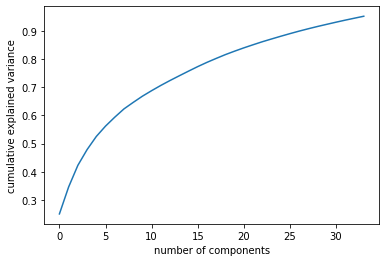

In [47]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [48]:
pca.n_components_

34

95 percent of the variance amounts to 50 principal components

In [49]:
#apply the pca transformations to the training & testing data
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [50]:
X_test

array([[ 1.31677941e+00, -2.11670391e+00, -1.33579421e+00, ...,
        -6.14868194e-01, -4.82583014e-01, -1.27843087e-01],
       [ 1.65000329e+00, -3.74978315e+00, -6.66397852e-01, ...,
        -7.29893376e-01, -2.87025324e-01,  8.04085668e-03],
       [-5.46684784e-01,  4.96389678e+00,  5.96155715e+00, ...,
         2.81234717e-01,  4.98000210e-04,  1.86271974e+00],
       ...,
       [ 6.14286018e+00, -2.04820553e+00,  1.22416093e+00, ...,
         3.28695028e-01, -1.96981277e-01, -2.71868100e-01],
       [-4.12537842e+00,  1.98096157e+00, -6.42261957e-01, ...,
         1.07813384e-01, -4.82572840e-01,  5.50580120e-01],
       [-2.19300610e+00, -6.89991884e-01,  9.39121545e-01, ...,
        -1.17237506e-01,  2.80730411e-01,  6.17643827e-03]])

## Price Forecasting

At this moment our data is treated and ready to train models for price forecasting.

We begin our analysis by building an ARIMA model based on the training data's timeseries component and find its best order.

Secondly, we will train regular regression models and apply cross-validation and hyperparameter tuning to these models 

For Price Forecasting, we'll make use of the treated features above to feed regression models & also analyse the timeseries component of our data in a standalone ARIMA.

C:\Users\t_bor\Anaconda\Anaconda_NEW\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


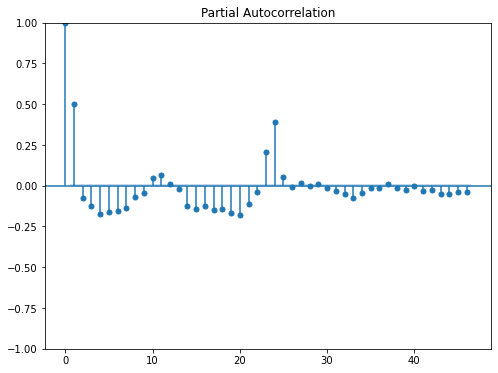

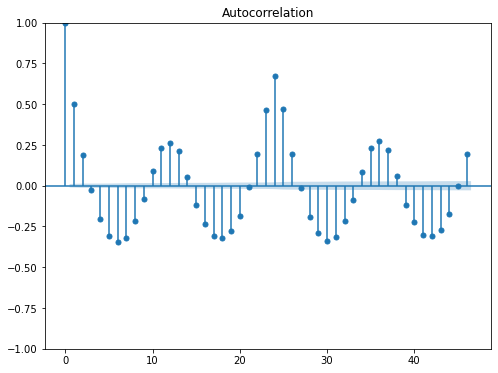

In [51]:
# Create a new figure and a single subplot
fig, ax = plt.subplots(figsize=(8, 6))

plot_pacf(df_final['price actual'].diff().dropna(), alpha=0.05, ax=ax)


# Create a new figure and a single subplot
fig, ax = plt.subplots(figsize=(8, 6))

plot_acf(df_final['price actual'].diff().dropna(), alpha=0.05, ax=ax)

plt.show()

By looking at the Autocorrelation & Partial Autocorrelation plots we observe some relevant spikes in both which might indicate some relevant autoregressive and moving average components our data should catch 

We use Auto-Arima to find the best possible ARIMA model (the one that minimizes AIC)

In [52]:
#RUNNING THE LINE BELOW TAKES CLOSE TO 15 MINUTES
stepwise_fit = auto_arima(df_final['price actual'].values, trace=True, seasonal=True, d=1, suppress_warnings=True) 

#by trial and error we found a d=1 (integration=1) performs better. intuitively this might be explained by the linear trend we found in the 'price actual plot' in the EDA phase

##### Running the code above returns:
```
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=175823.250, Time=23.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=190506.385, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=180506.267, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=181927.638, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=190504.385, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=176168.004, Time=20.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=175820.043, Time=44.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=175873.156, Time=26.71 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=175770.666, Time=49.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=175772.524, Time=26.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=175775.828, Time=22.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=173690.302, Time=60.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=175839.880, Time=53.78 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=173375.767, Time=73.41 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=63.16 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=171982.139, Time=58.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=57.35 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=78.53 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=64.77 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=88.33 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=32.76 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 863.575 seconds
```

In [53]:
#Our model of election is ARIMA(4,1,4)(0,0,0)[0] intercept
def ARIMA_model(data):
    arima_model = sm.tsa.arima.ARIMA(data, order = (4, 1, 4), trend='t') #trend= 't' referes to the intercept
    ts_model = arima_model.fit()
    return ts_model

C:\Users\t_bor\Anaconda\Anaconda_NEW\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\t_bor\Anaconda\Anaconda_NEW\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\t_bor\Anaconda\Anaconda_NEW\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


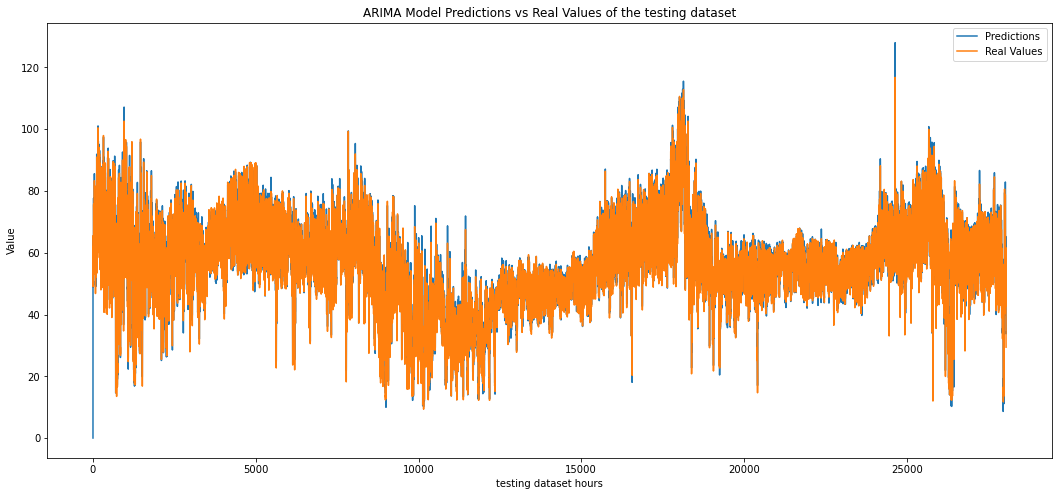

In [54]:
# Generate predictions for training dataset
ARIMA_414_model = ARIMA_model(df_final['price actual'][:y_train.size].reset_index(drop=True))

#getting model predictions
predictions_ARIMA = ARIMA_414_model.predict(dynamic=False)

# Set the figure size
plt.figure(figsize=(18, 8))  # Adjust the width and height as desired


# Plot the predictions
plt.plot(predictions_ARIMA, label='Predictions')

# Plot the real values
y_true = df_final['price actual'][:y_train.size].reset_index(drop=True)
plt.plot(df_final['price actual'][:y_train.size].reset_index(drop=True), label='Real Values')

# Add labels and title
plt.xlabel('testing dataset hours')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions vs Real Values of the testing dataset')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [55]:
rmse_model_ARIMA = np.mean((predictions_ARIMA - y_true)**2)**.5 #Root Mean Squared Error

print('The RMSE of the ARIMA(4,1,4) model with intercept is: ', rmse_model_ARIMA)

The RMSE of the ARIMA(4,1,4) model with intercept is:  3.0729215476109144


The model ARIMA(4,1,4) model with intercept seems to perform well within the training dataset. 
Since this is a model with Temporal Dependency, we cannot treat it as a regular regression model: In a real world deployment our case requires 4 lagged observations of the actual price of energy, in other words to predict the price of the current hour we'd need access to the prices of the past 4 hours.

To test this model, we apply it to the testing dataset & compare its predictions with the actual values.

C:\Users\t_bor\Anaconda\Anaconda_NEW\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


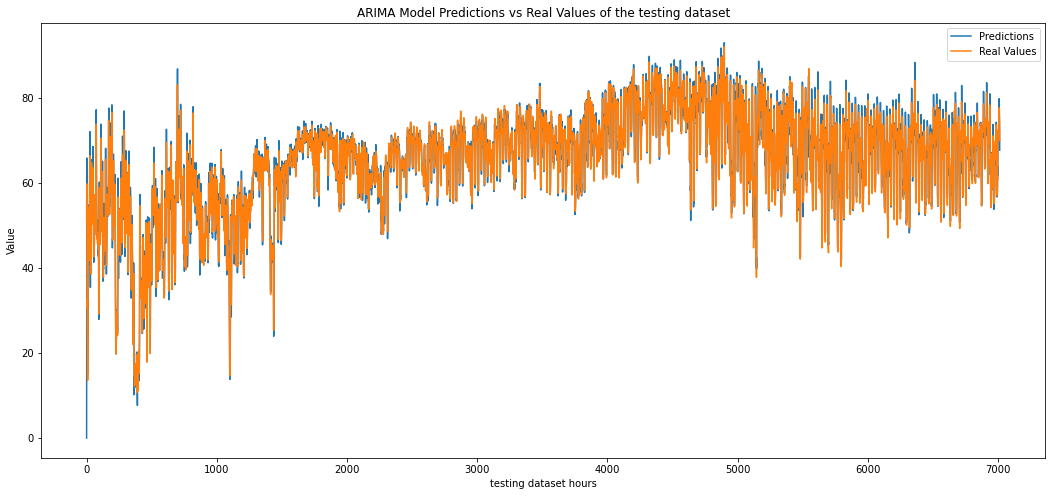

The RMSE of the ARIMA(4,1,4) model with intercept is:  2.470299129125315


In [56]:
# Generate predictions for training dataset
ARIMA_414_model_test = ARIMA_model(df_final['price actual'][y_train.size:].reset_index(drop=True))

#getting model predictions
predictions_ARIMA = ARIMA_414_model_test.predict(dynamic=False)


# Set the figure size
plt.figure(figsize=(18, 8))  # Adjust the width and height as desired


# Plot the predictions
plt.plot(predictions_ARIMA, label='Predictions')

# Plot the real values
y_actual = df_final['price actual'][y_train.size:].reset_index(drop=True)
plt.plot(df_final['price actual'][y_train.size:].reset_index(drop=True), label='Real Values')

# Add labels and title
plt.xlabel('testing dataset hours')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions vs Real Values of the testing dataset')

# Show legend
plt.legend()

# Display the plot
plt.show()


rmse_model_ARIMA = np.mean((predictions_ARIMA - y_actual)**2)**.5 #Root Mean Squared Error

print('The RMSE of the ARIMA(4,1,4) model with intercept is: ', rmse_model_ARIMA)

In [57]:
predictions_ARIMA.size

7013

We have performed a model entirely focused on the time-series component of our data. Now it's time to apply Regressor Models to complement our analysis.
First we begin by creating a XGBOOST Regressor which is known to perform well in this type of problem & isn't too intensive in terms of computational cost.

In [58]:
# create an xgboost regression model
model = XGBRegressor() #first we try the model with default parameters, our relevant evaluation metric is rmse (default)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3) #default Number of times cross-validator needs to be repeated is 10, but we assume 3 for a shorter processing time
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1) #RMSE for scoring
# force scores to be positive for evaluation
scores = absolute(scores)

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 7.292 (0.110)


In order to potentialy improve the performance of the model we create a small grid of parameters that might improve the performance of our model. This grid will take into consideration a small set of candidates as alternatives to the default parameters which will be selected by randome search with cross validation... hopefully we get better results without overfitting the data.

In [59]:
# Define the grid of hyperparameters to search for hyperparameter optimization
hyperparameter_grid = {
    'n_estimators': [80, 120],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.2, 0.3],
    'min_child_weight': [1, 2]
    }

# Set up a random search with 4-fold cross validation to find the best possible hyperparameters given the grid above
random_cv = RandomizedSearchCV(estimator = model,
            param_distributions = hyperparameter_grid,
            cv = 5, 
            n_iter = 20,
            scoring = 'neg_root_mean_squared_error',n_jobs = 4,
            return_train_score = True,
            random_state = 42)

random_cv.fit(X_train,y_train)
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
model_xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=2, monotone_constraints='()',
             n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3) #default Number of times cross-validator needs to be repeated is 10, but we assume 3 for a shorter processing time
# evaluate model
scores = cross_val_score(model_xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1) #RMSE for scoring
# force scores to be positive for evaluation
scores = absolute(scores)

rmse_model_XGB = scores.mean()

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 6.844 (0.097)


In [61]:
#fitting data into our best xgbregressor
model_xgb.fit(X_train, y_train)
#Predicting Training dataset
predictions_XGB = model_xgb.predict(X_test)

We have already trained a regressor and an ARIMA, nevertheless adding another model with a good performance might help with the quality of our forecast. The goal will be to use the weighted average of predictions from a selected set of models based on their RMSE.

For now we test if a Ridge Regression is a good idea for our forecast based on the fact it handles nonlinear relationships well and tends to reduce overfitting and provide stability by reducing the impact of multicollinearity

In [63]:
# define model
model_RR = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model_RR, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean RMSE: %.3f' % abs(results.best_score_))
print('Config: %s' % results.best_params_)

Mean RMSE: 9.433
Config: {'alpha': 0.99}


In [64]:
# updating to the best model parameters -> alpha = 0.99
model_RR_imp = Ridge(alpha= 0.99)#Ridge(results.best_params_)

# evaluate model
scores = cross_val_score(model_RR_imp, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1) #RMSE for scoring
# force scores to be positive for evaluation
scores = absolute(scores)



rmse_model_RR = scores.mean()

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 9.433 (0.142)


Ridge Regression is the worst model so far in terms of the RMSE score and hyperparameter tuning didn't seem to cause any improvement, perhaps we should find a better performing regressor model that can also handle nonlinear relationships.
SVR(Support Vector Regression) has shown good results when applied to various energy price forecasting tasks hence we will test it for our dataset and see if we reach a better prediction than the model above.

In [65]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
regressor_svr = SVR(kernel = 'rbf')
#We already scaled our data before applying PCA hence we directly fit X_train into it
regressor_svr.fit(X_train, y_train)

#getting model predictions
y_pred_svr = regressor_svr.predict(X_test)



In [66]:
# evaluate model
scores = cross_val_score(regressor_svr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1) #RMSE for scoring
# force scores to be positive for evaluation
scores = absolute(scores)

rmse_model_SVR = scores.mean()

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 7.625 (0.150)


The SVR has a considerably better RSME than the Ridge Regression, and very similar to the XGBoost (which is known to perform very well in this type of datasets).

As proposed, to improve the quality of the predictions we combine the best models to predict our target based on their weighted RMSE scores. The models of election are:

    -ARIMA (4,1,4) with intercept
    -XGBoost
    -SVR



In [67]:
predictions_ARIMA

0       -0.005668
1       50.945065
2       65.806602
3       41.448658
4       38.948527
          ...    
7008    79.754630
7009    78.084530
7010    76.480386
7011    73.619800
7012    67.643185
Name: predicted_mean, Length: 7013, dtype: float64

In [68]:
# Assign weights based on RMSE (lower RMSE gets higher weight)
weight_model_ARIMA = (1 / rmse_model_ARIMA)**2
weight_model_XGB = (1 / rmse_model_XGB)**2
weight_model_SVR = (1 / rmse_model_SVR)**2

# Normalize the weights
total_weight = weight_model_ARIMA + weight_model_XGB + weight_model_SVR
weight_model_ARIMA_normalized = weight_model_ARIMA / total_weight
weight_model_XGB_normalized = weight_model_XGB / total_weight
weight_model_SVR_normalized = weight_model_SVR / total_weight

# Calculate the weighted average
weighted_avg_predictions = (weight_model_ARIMA_normalized * predictions_ARIMA) + (weight_model_XGB_normalized * predictions_XGB) + (weight_model_SVR_normalized * y_pred_svr)

In [69]:
rmse_model_ARIMA = np.mean((weighted_avg_predictions - y_actual)**2)**.5 #Root Mean Squared Error

print('The RMSE of the combined model is: ', rmse_model_ARIMA)

The RMSE of the combined model is:  4.033593303159748


By combining the models we actually have a worse RMSE score (4.03) at predicting energy prices when compared to the standalone ARIMA(4,1,4) model with intercept (2.470299129125315).

To conclude, if we had to deploy a model for "hour-ahead" price prediction, we would be better-off by relying solely on our ARIMA model. In case the temporary dependency of the ARIMA could not be met (implying we'd be lacking the 4 hours of data prior to the hour we want to predict), we would need to rely on the regressors, and probably use a mix of both SVR & XGBOOST.